<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Lab-CNN-part-2:-Using-a-pretrained-convnet" data-toc-modified-id="Lab-CNN-part-2:-Using-a-pretrained-convnet-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Lab CNN part 2: Using a pretrained convnet</a></span></li><li><span><a href="#-Section-1:-Feature-extraction-" data-toc-modified-id="-Section-1:-Feature-extraction--2"><span class="toc-item-num">2&nbsp;&nbsp;</span><font color="purple"> Section 1: Feature extraction </font></a></span><ul class="toc-item"><li><span><a href="#Instantiating-the--VGG16--convolutional-base" data-toc-modified-id="Instantiating-the--VGG16--convolutional-base-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Instantiating the <font color="red"> VGG16 </font> convolutional base</a></span><ul class="toc-item"><li><span><a href="#-Option-1:-Extracting-features-using-the-pretrained-convolutional-base-" data-toc-modified-id="-Option-1:-Extracting-features-using-the-pretrained-convolutional-base--2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span><font color="#F57A07"> Option 1: Extracting features using the pretrained convolutional base </font></a></span></li><li><span><a href="#-Option-2:--Adding-a-densely-connected-classifier-on-top-of-the-convolutional-base-(Training-the-model-end-to-end-with-a-frozen-convolutional-base)-" data-toc-modified-id="-Option-2:--Adding-a-densely-connected-classifier-on-top-of-the-convolutional-base-(Training-the-model-end-to-end-with-a-frozen-convolutional-base)--2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span><font color="F57A07"> Option 2:  Adding a densely connected classifier on top of the convolutional base (Training the model end to end with a frozen convolutional base) </font></a></span></li><li><span><a href="#Training-the-model-end-to-end-with-a-frozen-convolutional-base" data-toc-modified-id="Training-the-model-end-to-end-with-a-frozen-convolutional-base-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Training the model end to end with a frozen convolutional base</a></span></li></ul></li></ul></li><li><span><a href="#-Section-2:-Fine-Tuning-" data-toc-modified-id="-Section-2:-Fine-Tuning--3"><span class="toc-item-num">3&nbsp;&nbsp;</span><font color="purple"> Section 2: Fine Tuning </font></a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Freezing-all-layers-up-to-a-specific-one" data-toc-modified-id="Freezing-all-layers-up-to-a-specific-one-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>Freezing all layers up to a specific one</a></span></li></ul></li></ul></li></ul></div>

# Lab CNN part 2: Using a pretrained convnet

A common and highly effective approach to deep learning on small image datasets is
to use a pretrained network.

A pretrained network is a saved network that was previously trained on a large dataset

There are two ways to use a pretrained network: <font color = red > feature extraction and fine-tuning. </font>
We’ll cover both of them. Let’s start with feature extraction.

# <font color = 'purple'> Section 1: Feature extraction </font>

Feature extraction consists of using the representations learned by a previous network
to extract interesting features from new samples. These features are then run through
a new classifier, which is trained from scratch.

 As you saw previously, convnets used for image classification comprise two parts:
 
- they start with a series of pooling and convolution layers, 
- and they end with a densely connected classifier. 

The first part is called the convolutional base of the model. In the case of convnets, feature extraction consists of taking the convolutional base of a previously trained network, running the new data through it, and training a new classifier on top of the output

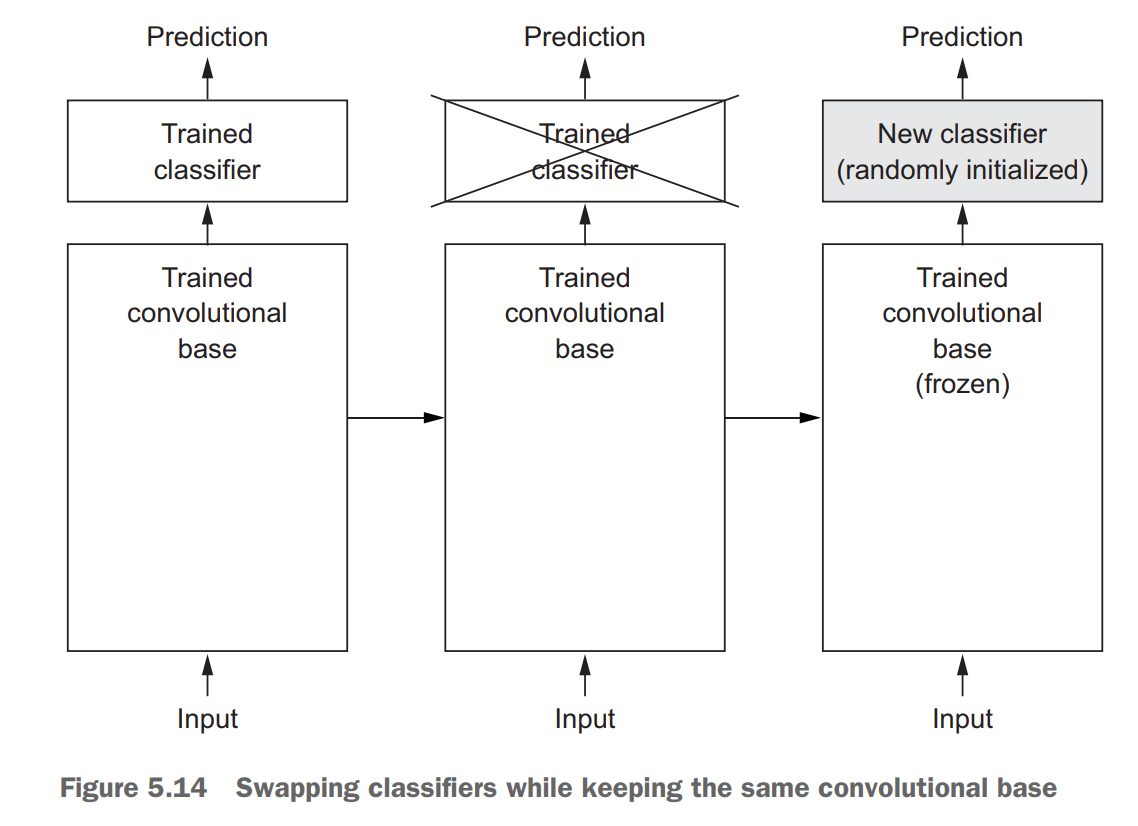

##  Instantiating the <font color = red> VGG16 </font> convolutional base

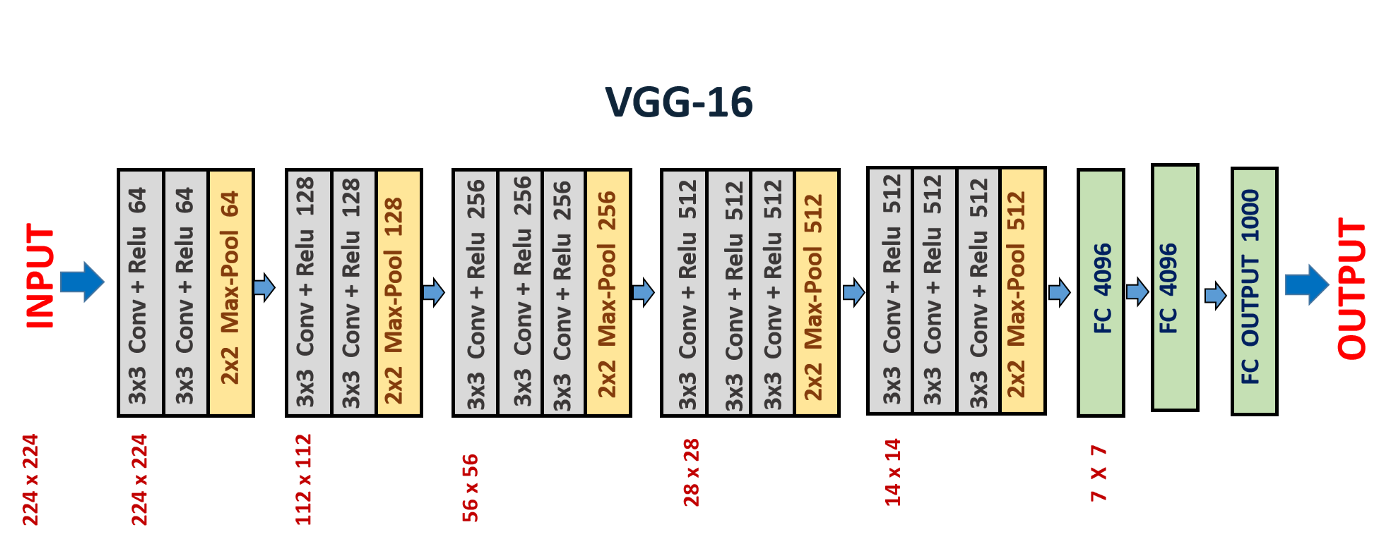

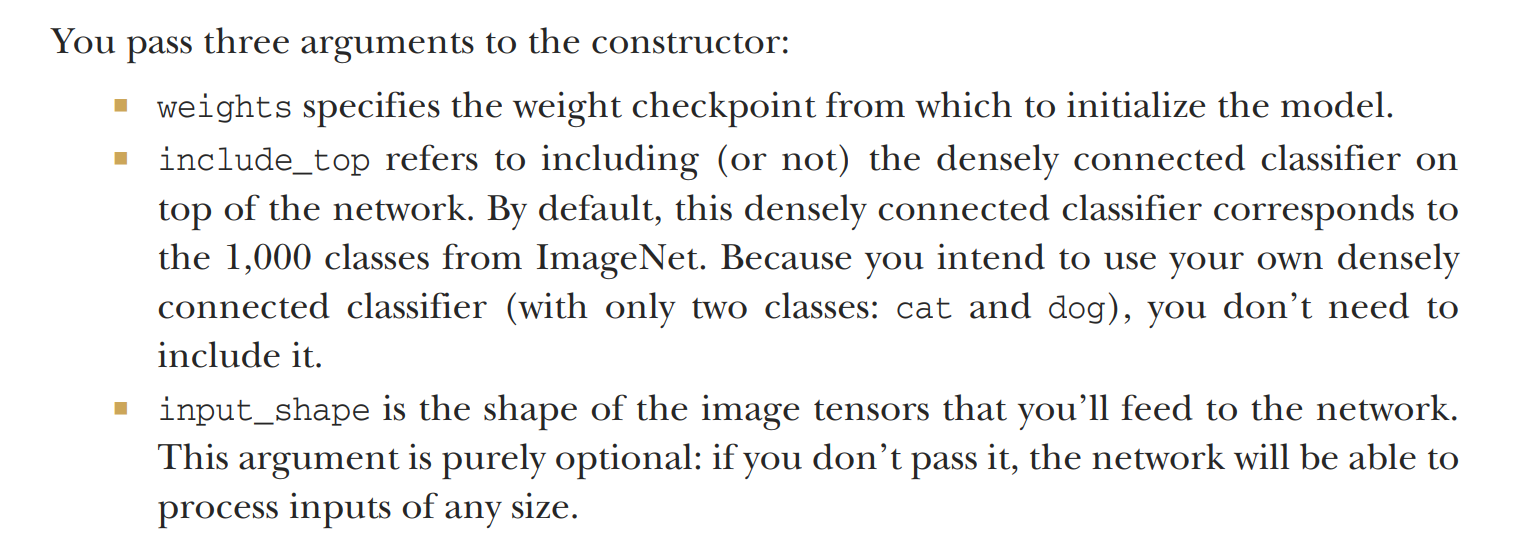

In [ ]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [16]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

The final feature map has shape (4, 4, 512). That’s the feature on top of which you’ll
stick a densely connected classifier.

<b> At this point, there are two ways you could proceed: </b>

- Running the convolutional base over your dataset, recording its output to a Numpy array on disk, and then using this data as input to a standalone, densely connected classifier similar. This solution is fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. But for the same reason, this technique won’t allow you to use data augmentation.

- Extending the model you have (conv_base) by adding Dense layers on top, and running the whole thing end to end on the input data. This will allow you to usedata augmentation, because every input image goes through the convolutional base every time it’s seen by the model. But for the same reason, this technique is far more expensive than the first.

### <font color = '#F57A07'> Option 1: Extracting features using the pretrained convolutional base </font>
#####  <font color = '#F57A07'> FAST FEATURE EXTRACTION WITHOUT DATA AUGMENTATION </font>

In [3]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [4]:
base_dir = '' 
train_dir = os.path.join(base_dir, 'training')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'testing')

In [5]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
                directory,
                target_size=(150, 150),
                batch_size=batch_size,
                class_mode='binary')
    
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        # Note that because generators yield data indefinitely in a loop, you must break after every
         #image has been seen once.
        if i * batch_size >= sample_count:
            break
    return features, labels

In [6]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
1/1 [==============================] - 1s 655ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 1s 682ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 1s 701ms/step


The extracted features are currently of shape (samples, 4, 4, 512). You’ll feed them
to a densely connected classifier, so first you must flatten them to (samples, 8192):

In [7]:
train_features = np.reshape(train_features, (2000, 4*4* 512))
validation_features = np.reshape(validation_features, (1000, 4*4* 512))
test_features = np.reshape(test_features, (1000, 4*4* 512))

At this point, you can define your densely connected classifier (note the use of dropout for regularization) and train it on the data and labels that you just recorded.

In [8]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()

model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))

model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5), loss='binary_crossentropy',metrics=['acc'])

history = model.fit(train_features, train_labels,
                epochs=30,
                batch_size=20,
                validation_data=(validation_features, validation_labels))

Epoch 1/30


100/100 [==============================] - 3s 14ms/step - loss: 0.5940 - acc: 0.6800 - val_loss: 0.4306 - val_acc: 0.8450
Epoch 2/30
100/100 [==============================] - 1s 11ms/step - loss: 0.4301 - acc: 0.8065 - val_loss: 0.3484 - val_acc: 0.8780
Epoch 3/30
100/100 [==============================] - 1s 11ms/step - loss: 0.3351 - acc: 0.8685 - val_loss: 0.3068 - val_acc: 0.8920
Epoch 4/30
100/100 [==============================] - 1s 11ms/step - loss: 0.2971 - acc: 0.8820 - val_loss: 0.2940 - val_acc: 0.8800
Epoch 5/30
100/100 [==============================] - 1s 11ms/step - loss: 0.2860 - acc: 0.8800 - val_loss: 0.2753 - val_acc: 0.8970
Epoch 6/30
100/100 [==============================] - 1s 12ms/step - loss: 0.2622 - acc: 0.8975 - val_loss: 0.2667 - val_acc: 0.8970
Epoch 7/30
100/100 [==============================] - 1s 10ms/step - loss: 0.2472 - acc: 0.9000 - val_loss: 0.2601 - val_acc: 0.8960
Epoch 8/30
100/100 [==============================] - 1s 9ms/step -

Training is very fast, because you only have to deal with two Dense layers—an epoch
takes less than one second even on CPU.

Let’s look at the loss and accuracy curves during training 

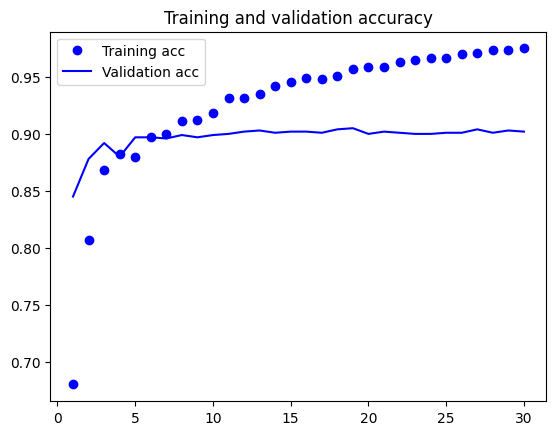

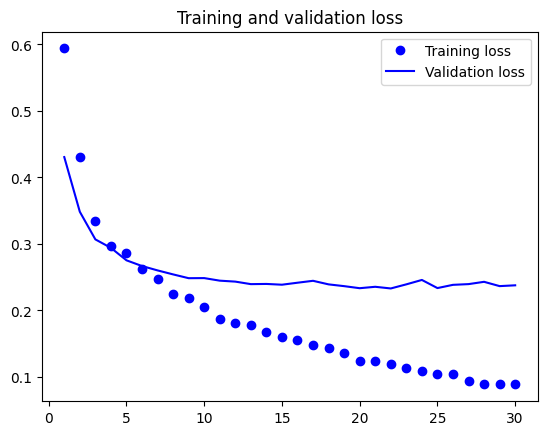

In [9]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### <font color = 'F57A07'> Option 2:  Adding a densely connected classifier on top of the convolutional base (Training the model end to end with a frozen convolutional base) </font>

#####  <font color = 'F57A07'> FEATURE EXTRACTION WITH DATA AUGMENTATION </font>

In [13]:
# Because models behave just like layers, you can add a model (like conv_base) to a
# Sequential model just like you would add a layer.

from keras import models
from keras import layers

model_2 = models.Sequential()

conv_base.trainable = False # Freeze the conv base

model_2.add(conv_base)

model_2.add(layers.Flatten())

model_2.add(layers.Dense(256, activation='relu'))

model_2.add(layers.Dense(1, activation='sigmoid'))

In [17]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 2097665 (8.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


As you can see, the convolutional base of VGG16 has 14,714,688 parameters, which is
very large. 

The classifier you’re adding on top has 2 million parameters.

Before you compile and train the model, it’s very important to <font color = red> freeze </font> the convolutional base. Freezing a layer or set of layers means preventing their weights from being
updated during training. 

If you don’t do this, then the representations that were previously learned by the convolutional base will be modified during training. Because
the Dense layers on top are randomly initialized, very large weight updates would be
propagated through the network, effectively destroying the representations previously
learned.

<font color = red> In Keras, you freeze a network by setting its trainable attribute to False </font>

In [12]:
# only the weights from the two Dense layers that you added will be trained. 
# That’s a total of four weight tensors: two per layer (the main weight matrix and the bias vector).



print('This is the number of trainable weights '
'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


 ### Training the model end to end with a frozen convolutional base

In [15]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=40,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size=(150, 150),
                    batch_size=20,
                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
                        validation_dir,
                        target_size=(150, 150), 
                        batch_size=20,
                        class_mode='binary')

model_2.compile(loss='binary_crossentropy',
                optimizer=optimizers.RMSprop(learning_rate=2e-5),
                metrics=['acc'])

history = model_2.fit(
            train_generator,
            steps_per_epoch=100,
            epochs=30,
            validation_data=validation_generator,
            validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 101s 995ms/step - loss: 0.5987 - acc: 0.6880 - val_loss: 0.4428 - val_acc: 0.8200
Epoch 2/30
100/100 [==============================] - 104s 1s/step - loss: 0.4731 - acc: 0.7850 - val_loss: 0.3603 - val_acc: 0.8600
Epoch 3/30
100/100 [==============================] - 104s 1s/step - loss: 0.4293 - acc: 0.8135 - val_loss: 0.3355 - val_acc: 0.8700
Epoch 4/30
100/100 [==============================] - 104s 1s/step - loss: 0.4003 - acc: 0.8220 - val_loss: 0.2961 - val_acc: 0.8860
Epoch 5/30
100/100 [==============================] - 105s 1s/step - loss: 0.3860 - acc: 0.8330 - val_loss: 0.2874 - val_acc: 0.8790
Epoch 6/30
100/100 [==============================] - 104s 1s/step - loss: 0.3627 - acc: 0.8465 - val_loss: 0.2764 - val_acc: 0.8840
Epoch 7/30
100/100 [==============================] - 108s 1s/step - loss: 0.3547 - acc: 0.8475 - val_loss: 0.2643 

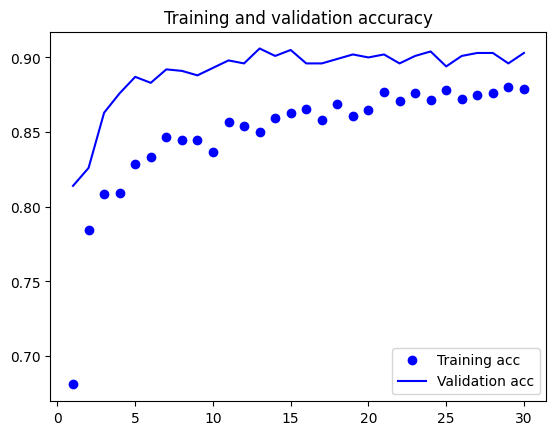

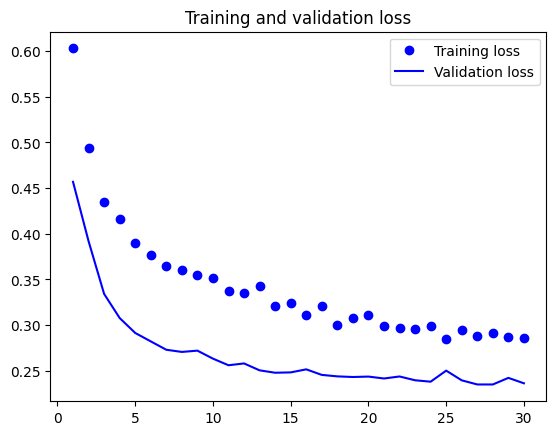

In [14]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# test_loss, test_acc = model.evaluate(test_generator, steps=50)

# print('test acc:', test_acc)

# <font color = 'purple'> Section 2: Fine Tuning (2nd Option) </font>

Another widely used technique for model reuse, complementary to feature
extraction, is fine-tuning (see figure 5.19). Fine-tuning consists of unfreezing a few of
the top layers of a frozen model base used for feature extraction, and jointly training
both the newly added part of the model (in this case, the fully connected classifier)
and these top layers. This is called fine-tuning because it slightly adjusts the more
abstract representations of the model being reused, in order to make them more relevant for the problem 

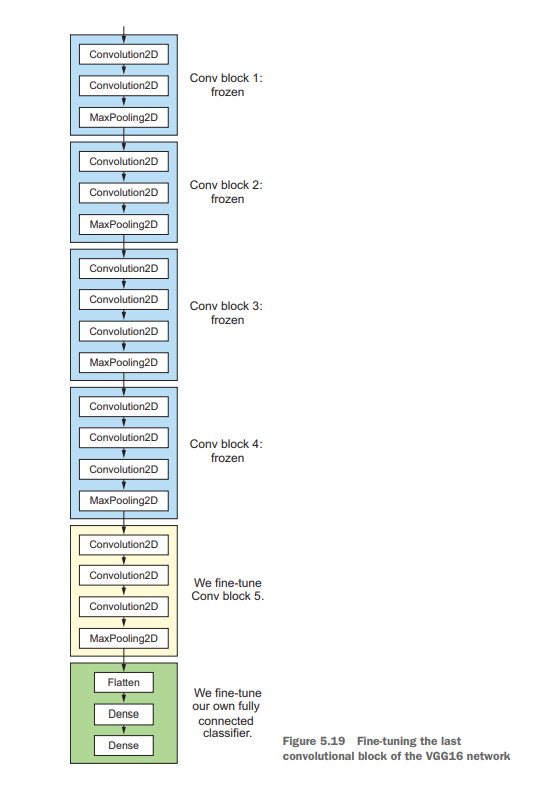

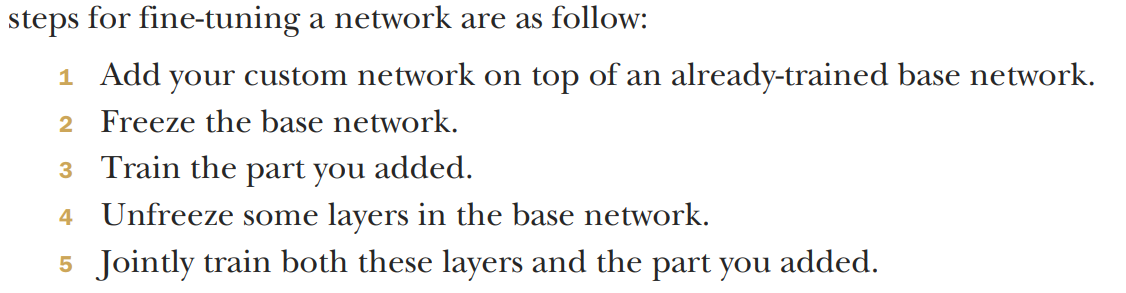

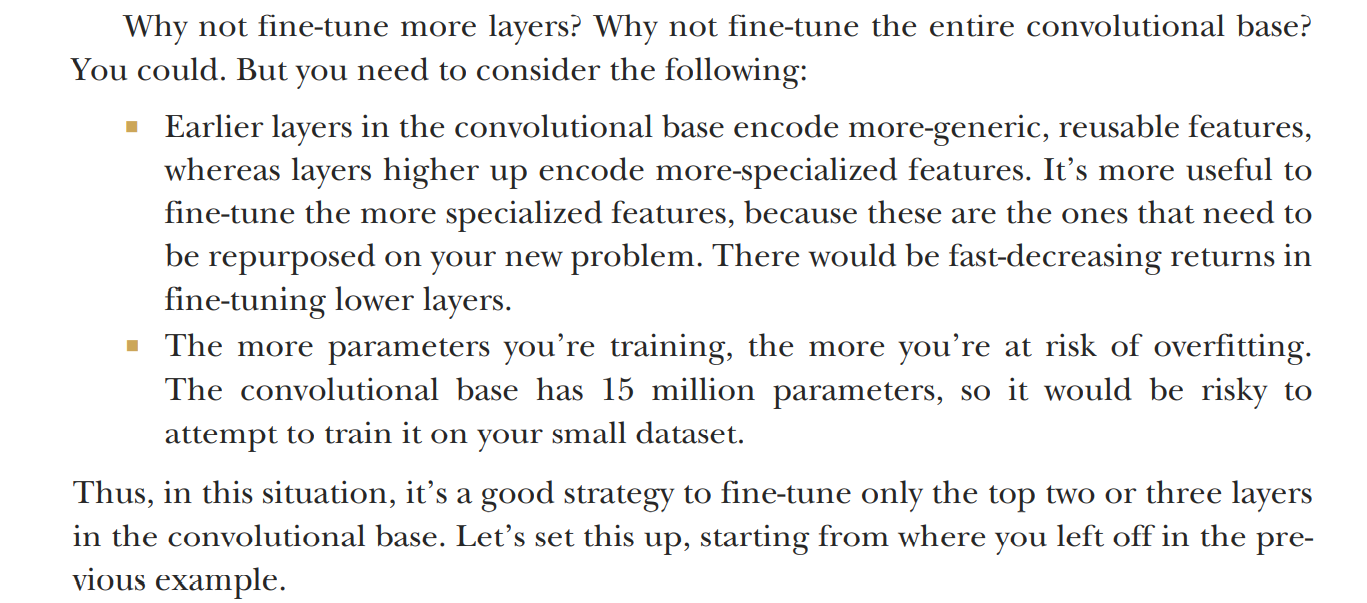

###  Freezing all layers up to a specific one

In [27]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':    # write the block you want to train
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model.compile(loss='binary_crossentropy',
            optimizer=optimizers.RMSprop(learning_rate=1e-5), # Choose reasonable learning rate
            metrics=['acc'])

history = model.fit(
            train_generator,
            steps_per_epoch=100,
            epochs=100,
            validation_data=validation_generator,
            validation_steps=50)

Epoch 1/100
100/100 [==============================] - 130s 1s/step - loss: 0.3315 - acc: 0.8525 - val_loss: 0.2252 - val_acc: 0.9010
Epoch 2/100
100/100 [==============================] - 128s 1s/step - loss: 0.3025 - acc: 0.8650 - val_loss: 0.2347 - val_acc: 0.9020
Epoch 3/100
100/100 [==============================] - 129s 1s/step - loss: 0.2518 - acc: 0.9020 - val_loss: 0.2044 - val_acc: 0.9210
Epoch 4/100
100/100 [==============================] - 128s 1s/step - loss: 0.2411 - acc: 0.8980 - val_loss: 0.1807 - val_acc: 0.9220
Epoch 5/100
100/100 [==============================] - 128s 1s/step - loss: 0.2160 - acc: 0.9150 - val_loss: 0.1827 - val_acc: 0.9200
Epoch 6/100
100/100 [==============================] - 129s 1s/step - loss: 0.2148 - acc: 0.9000 - val_loss: 0.1788 - val_acc: 0.9280
Epoch 7/100
100/100 [==============================] - 134s 1s/step - loss: 0.2114 - acc: 0.9130 - val_loss: 0.1725 - val_acc: 0.9230
Epoch 8/100
100/100 [==============================] - 128s 1s

Epoch 62/100
100/100 [==============================] - 124s 1s/step - loss: 0.0317 - acc: 0.9895 - val_loss: 0.2730 - val_acc: 0.9300
Epoch 63/100
100/100 [==============================] - 124s 1s/step - loss: 0.0343 - acc: 0.9875 - val_loss: 0.2403 - val_acc: 0.9390
Epoch 64/100
100/100 [==============================] - 124s 1s/step - loss: 0.0240 - acc: 0.9905 - val_loss: 0.2233 - val_acc: 0.9410
Epoch 65/100
100/100 [==============================] - 125s 1s/step - loss: 0.0356 - acc: 0.9865 - val_loss: 0.2870 - val_acc: 0.9320
Epoch 66/100
100/100 [==============================] - 124s 1s/step - loss: 0.0394 - acc: 0.9830 - val_loss: 0.2639 - val_acc: 0.9290
Epoch 67/100
100/100 [==============================] - 124s 1s/step - loss: 0.0326 - acc: 0.9870 - val_loss: 0.2064 - val_acc: 0.9400
Epoch 68/100
100/100 [==============================] - 124s 1s/step - loss: 0.0416 - acc: 0.9875 - val_loss: 0.2549 - val_acc: 0.9350
Epoch 69/100
100/100 [==============================] -

In [30]:
test_generator = test_datagen.flow_from_directory(
                test_dir,
                target_size=(150, 150),
                batch_size=20,
                class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=50)

print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 41s 826ms/step - loss: 0.3578 - acc: 0.9370
test acc: 0.9369999766349792
